In this notebook, I will show how to use the `segmentation_models` library ([GitHub link](https://github.com/qubvel/segmentation_models)) to perform transfer learning and fine-tuning on a custom dataset (Brain MRI segmentation) obtained from [Kaggle](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation).

This notebook was used to train in Google Colab. Therefore, it is better to just open this notebook in Google Colab, you may refer to the Google Colab notebook [here](https://colab.research.google.com/drive/1dcQ_p3CVytqnUrvl3Xie4JbDqS5Q031M?usp=sharing#scrollTo=063d8153-6b86-4d0a-b59b-6c7fdcd5ca45).

# Setup

In [ ]:
# must install this library to use in Google Colab
!pip install segmentation_models

     |████████████████████████████████| 50 kB 6.2 MB/s 


In [1]:
import os
import time

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import segmentation_models as sm
# must set this to work for tf.keras
sm.set_framework('tf.keras')
sm.framework()
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


'tf.keras'

In [2]:
tf.__version__

'2.5.0'

You may choose to download the dataset from Kaggle and upload the entire dataset into Google Drive directly for faster upload time than uploading to here directly. Or just directly download the dataset into the Google Colab environment here by using Kaggle API. 

1. Go to homepage www.kaggle.com -> Your Account -> Create New API token and a `kaggle.json` file will be downloaded.
2. Upload the `kaggle.json` file to Google Colab at the left panel.
3. Then, run the cell below to create a kaggle directory and copy the `kaggle.json` API key into the directory.

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 708M/714M [00:05<00:00, 131MB/s]
100% 714M/714M [00:05<00:00, 147MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Wed Aug 25 11:22:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     8W /  75W |      2MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# set the random seed for random number generator to produce 
# similar results every time
np.random.seed(42)
tf.random.set_seed(42)

# Config

Download and copy the file contents from [Kaggle](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) into the "dataset" folder in the root directory of this project.

In [ ]:
# define the directory to your images
ORIGINAL_DATA_DIR = os.path.join("lgg-mri-segmentation", "kaggle_3m")
print(f"Directory '{ORIGINAL_DATA_DIR}' exists: {os.path.exists(ORIGINAL_DATA_DIR)}")

Directory 'lgg-mri-segmentation/kaggle_3m' exists: True


In [ ]:
# Set up the splitting ratio for the 3 separate sets
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
TRAIN_SPLIT = 1.0 - TEST_SPLIT - VAL_SPLIT
TRAIN_SPLIT

0.8

In [ ]:
# the image size that we want to resize into for training
IMG_HEIGHT = 256
IMG_WIDTH = 256
# 3 channels for our RGB images
IMG_CHANNELS = 3

## Training config

In [ ]:
BATCH_SIZE = 16
# learning_rate
LR = 0.05
EPOCHS = 60

In [ ]:
# we are using ResNet-50 as our backbone in this case,
# this will be provided by the segmentation_models libraray
BACKBONE = 'resnet50'
# don't need to include background for only 1 class
CLASSES = ['tumor']
N_CLASSES = 1
# get the backbone's preprocessing function from the library
preprocess_input = sm.get_preprocessing(BACKBONE)

Available backbones from the `segmentation_models` library shown in [GitHub](https://github.com/qubvel/segmentation_models):

![sm-backbones](images/segmentation-backbones.png)

# Prepare dataset

In [ ]:
all_image_paths = list(paths.list_images(ORIGINAL_DATA_DIR))
len(all_image_paths)

7858

In [ ]:
imagePaths = []
maskPaths = []
for img_path in all_image_paths:
    if "mask" in img_path:
        # mask images ends with "_mask.tif"
        maskPaths.append(img_path)
    else:
        imagePaths.append(img_path)

print(len(imagePaths))
print(len(maskPaths))

3929
3929


In [ ]:
imagePaths[0]

'lgg-mri-segmentation/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_2.tif'

In [ ]:
# defining the lengths to extract the unique numbers from the images and masks
BASE_LEN = len('lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_')
END_IMG_LEN = 4
END_MASK_LEN = 9

In [ ]:
# showing example of extracted numbers
imagePaths[0][BASE_LEN:-END_IMG_LEN], maskPaths[0][BASE_LEN:-END_MASK_LEN]

('19951103_2', '19951103_10')

In [ ]:
def get_img_number(path):
    return int(path[BASE_LEN:-END_IMG_LEN])

def get_mask_number(path):
    return int(path[BASE_LEN:-END_MASK_LEN])

# sort them according to unique numbers in filenames to align
# the images with the corresponding masks
imagePaths = sorted(imagePaths, key=get_img_number)
maskPaths = sorted(maskPaths, key=get_mask_number)

In [ ]:
# sanity check
random_idxs = np.random.randint(len(imagePaths), size=10)
for idx in random_idxs:
    print(imagePaths[idx])
    print(maskPaths[idx])
    print()

lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_30.tif
lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_30_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_13.tif
lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_13_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6.tif
lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_42.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_42_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_23.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_1983

# Inspecting dataset

In [ ]:
%%time
# checking the unique pixel values present in the dataset
# 255 is used to represent the presence of tumor in this case
all_unique_pixels = set()
for mask_path in maskPaths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    unique_pixels = np.unique(mask)
    if len(unique_pixels) > len(all_unique_pixels):
        all_unique_pixels.update(unique_pixels)
print(all_unique_pixels)

{0, 255}
CPU times: user 3.64 s, sys: 150 ms, total: 3.79 s
Wall time: 3.78 s


In [ ]:
## checking how many mask images have or do not have tumor presence

masks_true = []
masks_false = []
for i, mask_path in enumerate(maskPaths):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if len(np.unique(mask)) > 1:
        masks_true.append(i)
    else:
        masks_false.append(i)

print(f"{len(masks_true)} mask images with tumor")
print(f"{len(masks_false)} mask images without tumor")

1373 mask images with tumor
2556 mask images without tumor


In [ ]:
# take only dataset with tumors for training
X = np.array(imagePaths)[masks_true]
y = np.array(maskPaths)[masks_true]

In [ ]:
# checking
X[10], y[10]

('lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_9.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_9_mask.tif')

In [ ]:
def visualize(img, mask):
    # reshape to allow visualizing
    reshaped_mask = mask.reshape(IMG_HEIGHT, IMG_WIDTH).astype(np.uint8)
    unique_pixels = np.unique(reshaped_mask)

    plt.figure(figsize=(15, 8))
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(reshaped_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    # replace the tumor pixel value with another color to display it
    img[reshaped_mask==unique_pixels[1]] = (0,255,150) 
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

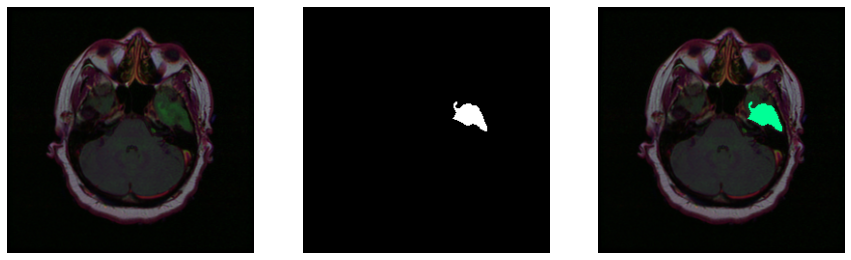

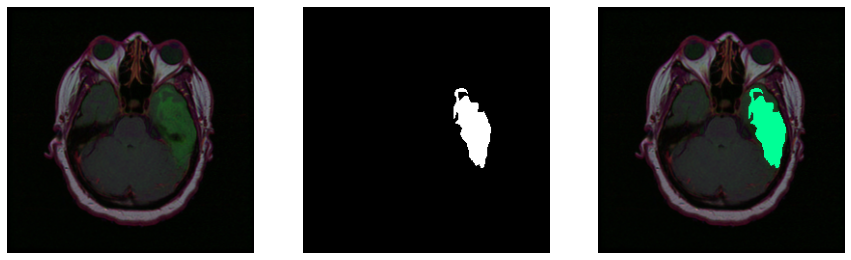

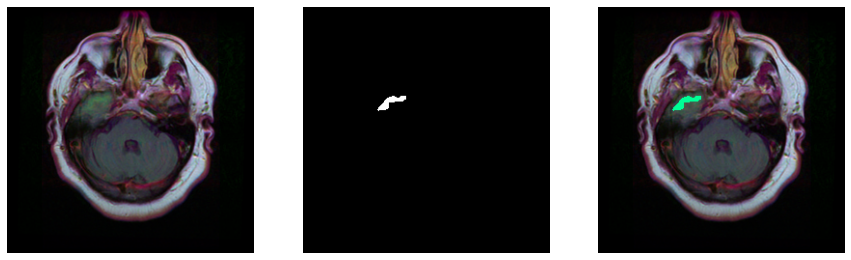

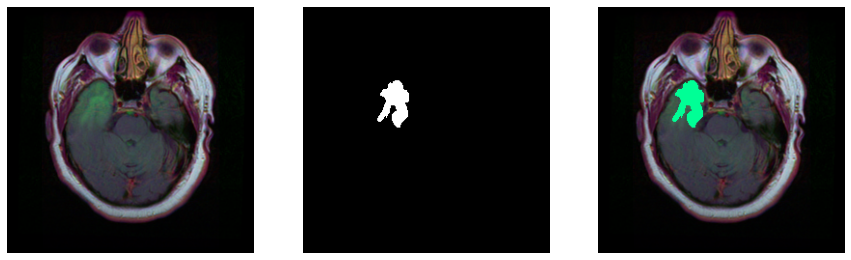

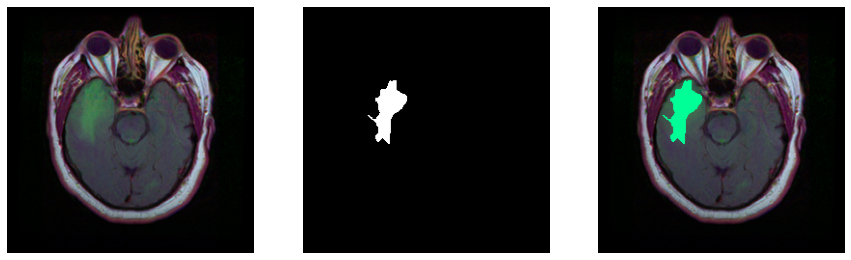

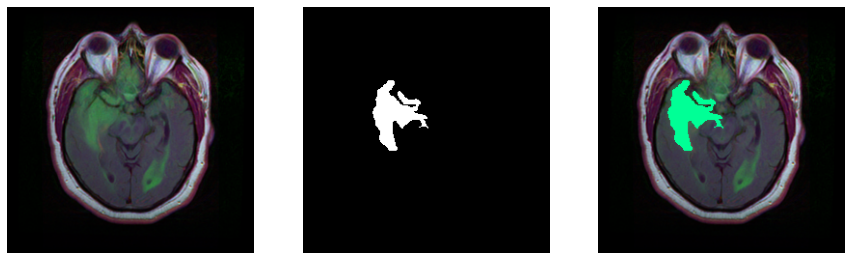

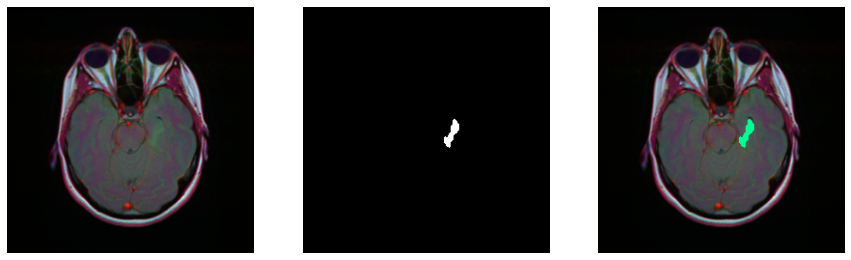

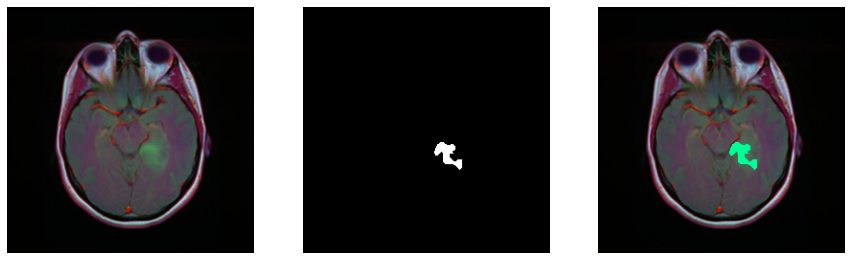

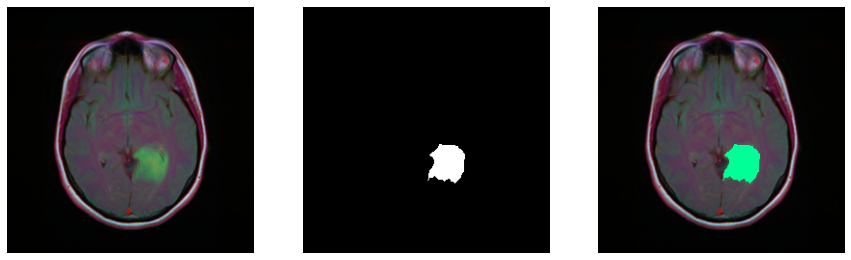

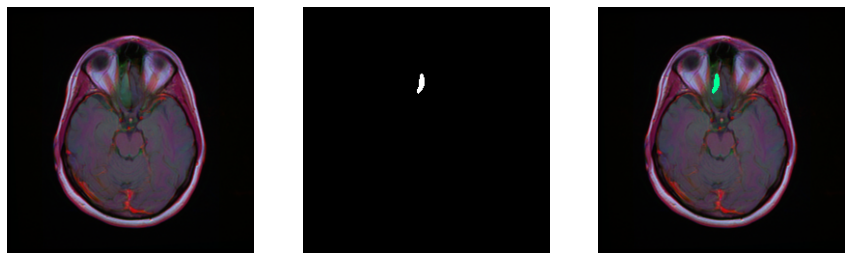

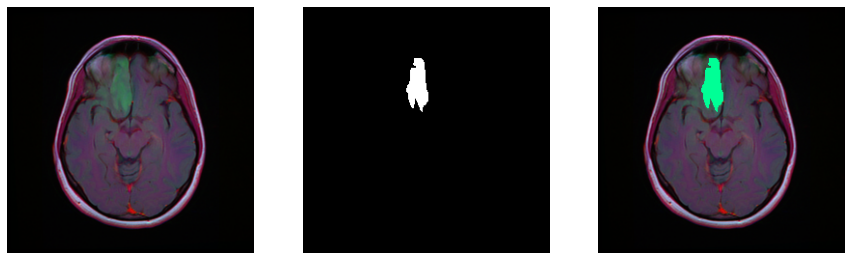

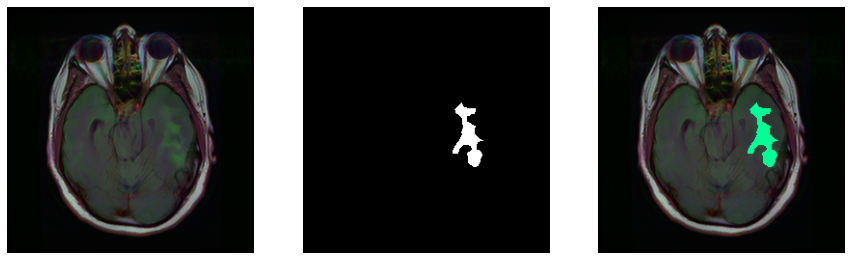

In [ ]:
n_samples = 12

for i, (img_path, mask_path) in enumerate(zip(X, y)):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if i == n_samples:
        break
    visualize(img, mask)
    plt.show()

# Split to train, validation, test datasets

In [ ]:
print(TRAIN_SPLIT)
print(VAL_SPLIT)
print(TEST_SPLIT)

0.8
0.1
0.1


Keep in mind that the `train_test_split` function provided by `sklearn` actually already shuffles the data when splitting.

In [ ]:
# split the dataset into rain:valid:test of ratio TRAIN_SPLIT:VAL_SPLIT:TEST_SPLIT
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)),
    random_state=42,
)

trainPct = len(X_train) / len(X) * 100
valPct = len(X_val) / len(X) * 100
testPct = len(X_test) / len(X) * 100

print(f"Total images = {len(X)}")
print(f"Total training images = {len(y_train)} ({trainPct:.1f} %)")
print(f"Total validation images = {len(y_val)} ({valPct:.1f} %)")
print(f"Total testing images = {len(y_test)} ({testPct:.1f} %)")

Total images = 1373
Total training images = 1098 (80.0 %)
Total validation images = 137 (10.0 %)
Total testing images = 138 (10.1 %)


In [ ]:
# making sure the image and the mask paths align again
X_train[15], y_train[15]

('lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_23.tif',
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_23_mask.tif')

lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24_mask.tif


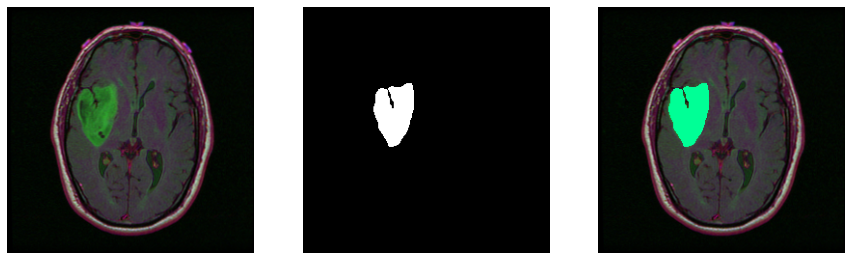

In [ ]:
## visualize a random sample

random_idx = np.random.randint(len(X_train))
img_path = X_train[random_idx]
mask_path = y_train[random_idx]
print(img_path)
print(mask_path)

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

visualize(img, mask)

<br>

NOTE: We are not creating new folders and copying them to the folders this time. This step is actually optional, although we have been doing it in the previous projects.

# Preparing tf.data.Dataset

In [ ]:
# similar to previous notebook
def read_image(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.astype(np.float32) / 255.
    return img

def read_mask(maskPath):
    mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    # changing the pixel value from 255 to 1
    mask = (mask / 255).astype(np.uint8)
    return mask

In [ ]:
def preprocess_data(imagePath, maskPath):
    def py_func(imagePath, maskPath):
        # need to decode the strings because Tensorflow
        # automatically changed them into bytes for some reason
        imagePath = imagePath.decode()
        maskPath = maskPath.decode()
        
        img = read_image(imagePath)
        # added the preprocess_input function from the sm library
        img = preprocess_input(img)
        
        mask = read_mask(maskPath)
        return img, mask
    
    # wrap the function and use it as a TF operation
    # to optimize for performance
    img, mask = tf.numpy_function(
        py_func,
        [imagePath, maskPath],
        [tf.float32, tf.uint8]
    )
    
    # add the last dimension for 1-channel mask
    mask = tf.expand_dims(mask, axis=-1)
    
    # set the shape to let TensorFlow knows about the shape
    # just like `assert` statements to ensure the shapes are correct
    # NOTE: this step is required to show metrics during training
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])
    
    return img, mask

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds
            .map(preprocess_data,
                 num_parallel_calls=AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (val_ds
          .map(preprocess_data,
               num_parallel_calls=AUTOTUNE)
)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (test_ds
           .map(preprocess_data,
                num_parallel_calls=AUTOTUNE)
)

In [ ]:
for img, mask in train_ds.take(1):
    # the mask is only 1 channel for 1 class in this case
    print(img.shape)
    print(img.dtype)
    print(mask.shape)
    print(mask.dtype)

(256, 256, 3)
<dtype: 'float32'>
(256, 256, 1)
<dtype: 'uint8'>


In [ ]:
# After testing, the `preprocess_input` function did not scale the images,
# therefore I scaled it myself in the `read_image` function
img.numpy().max()

0.9411765

In [ ]:
# 1 represents the pixel with tumor
np.unique(mask.numpy())

array([0, 1], dtype=uint8)

# Optimize the tf.data.Dataset for performance

As explained in my previous notebooks for [image classification](https://colab.research.google.com/drive/1f4xl0Oy_3pQNdVRbyDNC-DNx8M21QT6Q?usp=sharing).

In [ ]:
train_ds = (train_ds
            .shuffle(len(X_train))
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

val_ds = (val_ds
          # no shuffle
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
)

test_ds = (test_ds
           # no shuffle
           .cache()
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE)
)

# Build model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create the output path to save our model and weights
OUTPUTS_PATH = "/content/drive/MyDrive/outputs"
os.makedirs(OUTPUTS_PATH, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUTS_PATH, "MRI_segmentation.h5")

In [ ]:
tf.keras.backend.clear_session()

# define network parameters
# NOTE: If we follow the method of the previous notebook and if there is only one class,
#  you should use 'sigmoid' with 'binary_crossentropy' instead of 
#  'softmax' with 'categorical_crossentropy'. But in this case, we use another
#  loss that we will define later
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# create model, optionally you may set 'encoder_weights' to 'imagenet' to
# use pre-trained weights on ImageNet
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,
                encoder_weights=None, encoder_freeze=False)

In [ ]:
n_classes, activation

(1, 'sigmoid')

In [ ]:
model.summary()

In [ ]:
'''
Defining the Focal Tversky loss for training, which is a better choice than
cross-entropy for semantic segmentation.
The link to the reference:
https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py
'''
K = tf.keras.backend

smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# also using IoU score provided by the library to monitor performance
model.compile(optimizer, loss=focal_tversky,
              metrics=[tversky, iou_score])

# Training

In [ ]:
## defining some extra callbacks to use, this is not necessary for training
#  they are just used for quality of life

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# this callback saves the checkpoint weights with the best `val_loss` every epoch
checkpoint_filepath = os.path.join(OUTPUTS_PATH, 'weights.h5')
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True,
)

# this callback will stop the training when the `val_loss` has not changed for
#   certain number of epochs, as specified by the `patience` parameter
# `restore_best_weights` is used to restore the model to the best checkpoint 
#   after training
early_stopping = EarlyStopping(patience=5, monitor='val_loss',
                               mode='min', restore_best_weights=True,
                               verbose=1,
)

# reducing learning rate when the `val_loss` does not go down for 3 (patience) epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                              verbose=1, patience=3, min_delta=0.0001,
                              factor=0.2
)

In [ ]:
%%time
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoints, early_stopping, reduce_lr]
)

Epoch 1/60
69/69 [==============================] - 39s 488ms/step - loss: 0.5154 - tversky: 0.5784 - iou_score: 0.3935 - val_loss: 0.9331 - val_tversky: 0.0905 - val_iou_score: 0.0291
Epoch 2/60
69/69 [==============================] - 33s 476ms/step - loss: 0.3931 - tversky: 0.7082 - iou_score: 0.5207 - val_loss: 0.9249 - val_tversky: 0.1010 - val_iou_score: 0.0327
Epoch 3/60
69/69 [==============================] - 33s 476ms/step - loss: 0.3975 - tversky: 0.7040 - iou_score: 0.5178 - val_loss: 0.8391 - val_tversky: 0.2047 - val_iou_score: 0.0979
Epoch 4/60
69/69 [==============================] - 33s 474ms/step - loss: 0.3713 - tversky: 0.7304 - iou_score: 0.5480 - val_loss: 0.8425 - val_tversky: 0.2086 - val_iou_score: 0.0886
Epoch 5/60
69/69 [==============================] - 33s 475ms/step - loss: 0.3562 - tversky: 0.7447 - iou_score: 0.5658 - val_loss: 0.5427 - val_tversky: 0.5640 - val_iou_score: 0.4398
Epoch 6/60
69/69 [==============================] - 33s 476ms/step - loss: 

In [ ]:
print("[INFO] Saving model ...")
model.save(MODEL_PATH, save_format="h5")

[INFO] Saving model ...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# careful that the custom metric name might be different sometimes
H.history.keys()

dict_keys(['loss', 'tversky', 'iou_score', 'val_loss', 'val_tversky', 'val_iou_score', 'lr'])

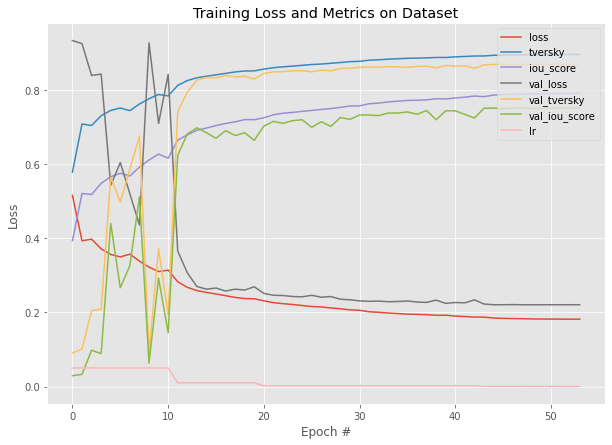

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
for key, values in H.history.items():
    plt.plot(values, label=key)
plt.title("Training Loss and Metrics on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

# Evaluation

In [ ]:
# load back model if necessary
# need to specify the custom losses and metrics used to be able to load
# the entire model. Don't forget to run the cells above for the custom loss
# and metrics first, and also the MODEL_PATH to your model
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects=dict(
        focal_tversky=focal_tversky,
        tversky=tversky,
        iou_score=iou_score
    )
)

In [ ]:
# the `evaluate` method will return the loss and any metric(s) we used
# in this case, they are: focal_tversky loss, tversky, and iou_score
values = model.evaluate(test_ds)
print(values)

9/9 [==============================] - 1s 129ms/step - loss: 0.2244 - tversky: 0.8643 - iou_score: 0.7449
[0.2243855744600296, 0.8643021583557129, 0.7448691129684448]


In [ ]:
# the predictions are in the shape of
# (n_samples, img_height, img_width, n_classes)
preds = model.predict(test_ds)
print(preds.shape)

(138, 256, 256, 1)


In [ ]:
threshold = 0.5

# we compare the probabilities with a threshold
# to classify whether the each pixel is a tumor or not.
# This is different from multiclass where we used argmax.
preds = (preds > threshold).astype(int)
preds = preds.reshape(-1, IMG_HEIGHT, IMG_WIDTH)
preds.shape

(138, 256, 256)

In [ ]:
np.unique(preds)

array([0, 1])

In [ ]:
## get the test images and masks

test_imgs = []
y_true = []

for img, mask in test_ds:
    test_imgs.append(img)
    y_true.append(mask)

test_imgs = np.concatenate(test_imgs, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_true = y_true.reshape(-1, IMG_HEIGHT, IMG_WIDTH)
test_imgs.shape, y_true.shape

((138, 256, 256, 3), (138, 256, 256))

In [ ]:
np.unique(y_true)

array([0, 1], dtype=uint8)

# Visualization of predictions

In [ ]:
# randomly select some predictions
random_idxs = np.random.randint(len(preds), size=5)
random_idxs

array([131,   1, 133,  53, 105])

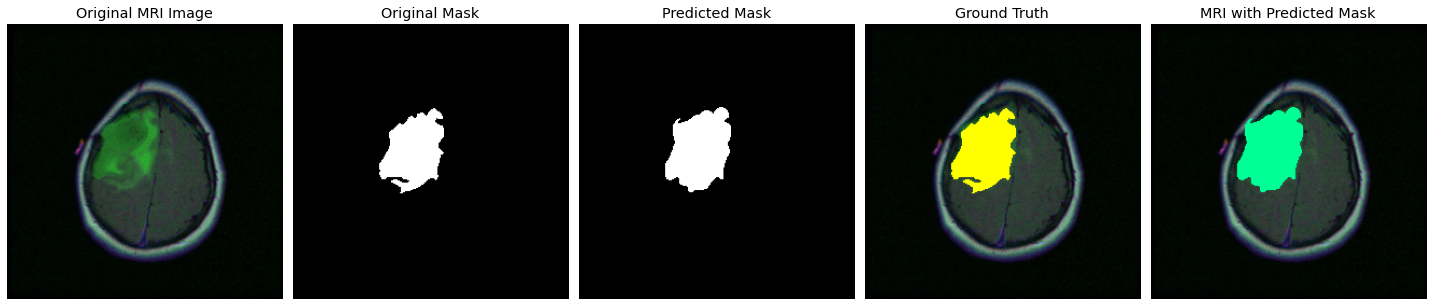

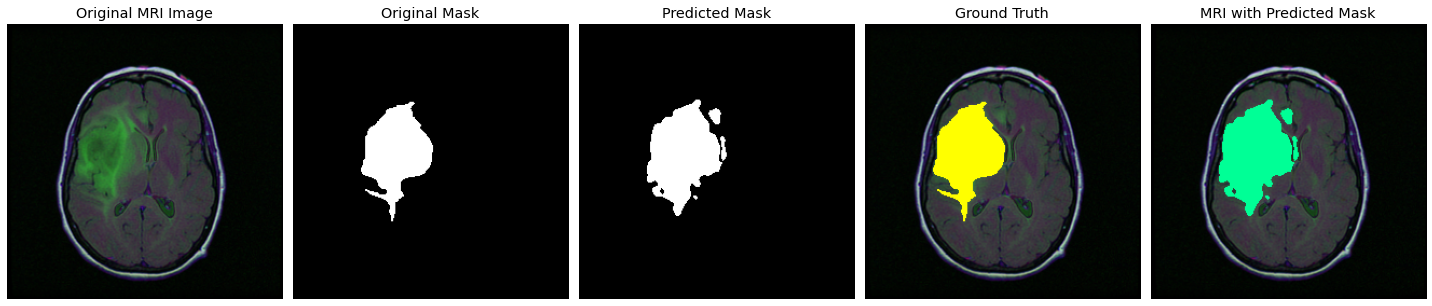

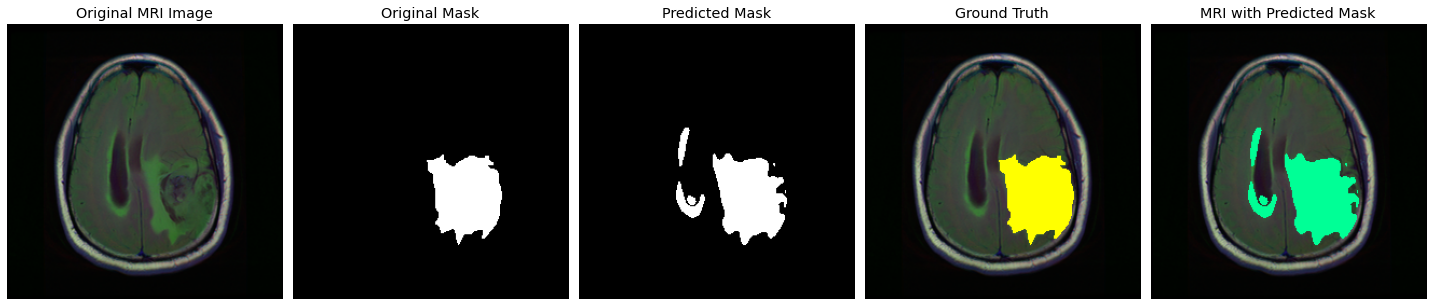

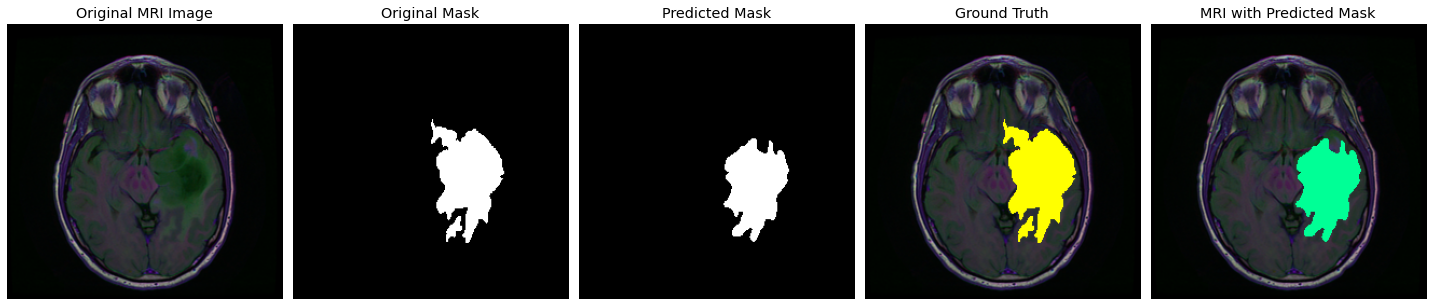

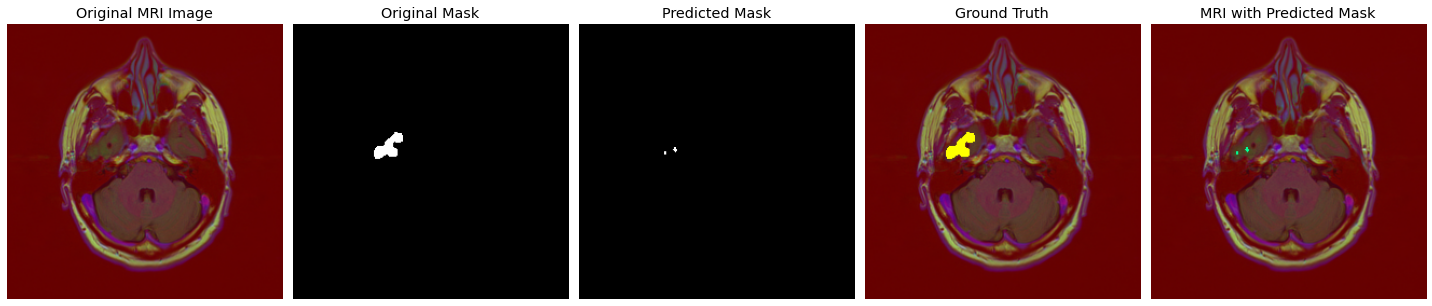

In [ ]:
for idx in random_idxs:
    ori_img = test_imgs[idx]
    y = y_true[idx]
    p = preds[idx]
    
    ori_img = (ori_img * 255).astype(np.uint8)

    reshaped_mask = y.reshape(IMG_HEIGHT, IMG_WIDTH).astype(np.uint8)
    unique_pixels = np.unique(reshaped_mask)

    p = p.astype(np.uint8)

    plt.figure(figsize=(20, 50))
    plt.subplot(151)
    plt.title("Original MRI Image")
    plt.imshow(ori_img)
    plt.axis('off')

    plt.subplot(152)
    plt.title("Original Mask")
    plt.imshow(reshaped_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(153)
    plt.title("Predicted Mask")
    plt.imshow(p, cmap='gray')
    plt.axis('off')
    
    plt.subplot(154)
    plt.title("Ground Truth")
    img = ori_img.copy()
    img[reshaped_mask == unique_pixels[1]] = (255,255,0) 
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(155)
    plt.title("MRI with Predicted Mask")
    ori_img[p == unique_pixels[1]] = (0,255,150) 
    plt.imshow(ori_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()